이 부분은 보이스피싱 및 전자상거래 관련 텍스트 데이터를 불러와서 TF-IDF 벡터화 및 라벨링을 수행하는 과정을 포함합니다. 다음은 코드의 각 단계에 대한 설명입니다:

1. **필요한 라이브러리 임포트**:
   - `pandas`: 데이터프레임을 생성하고 조작하는 데 사용됩니다.
   - `sklearn.feature_extraction.text.TfidfVectorizer`: 텍스트 데이터를 TF-IDF(Term Frequency-Inverse Document Frequency) 벡터로 변환하는 데 사용됩니다.
   - `networkx` 및 `matplotlib.pyplot`: 네트워크 그래프를 생성하고 시각화하는 데 사용됩니다. (이 코드는 나중에 그래프 시각화를 위해 사용될 수 있습니다.)

2. **데이터 로드**:
   ```python
   voicephishing_path = 'augmented_transcriptions.xlsx'
   ecommerce_path = 'combined_transcriptions.xlsx'

   voicephishing_data = pd.read_excel(voicephishing_path)
   ecommerce_data = pd.read_excel(ecommerce_path)
   ```
   두 개의 엑셀 파일에서 데이터를 불러옵니다:
   - `voicephishing_data`: 음성 피싱 관련 데이터
   - `ecommerce_data`: 전자상거래 관련 데이터

3. **데이터 라벨링**:
   ```python
   voicephishing_data['label'] = 1
   ecommerce_data['label'] = 0
   ```
   각 데이터셋에 라벨을 추가합니다:
   - `voicephishing_data`에는 라벨 1을 부여
   - `ecommerce_data`에는 라벨 0을 부여

4. **데이터 합치기**:
   ```python
   combined_data = pd.concat([voicephishing_data, ecommerce_data.sample(n=3000, random_state=42)])
   ```
   음성 피싱 데이터 전체와 전자상거래 데이터 중 3000개 샘플을 무작위로 선택하여 합칩니다. 이를 통해 두 클래스의 데이터 양을 맞춥니다.

5. **'transcript' 열을 문자열로 변환**:
   ```python
   combined_data['transcript'] = combined_data['transcript'].astype(str)
   ```
   'transcript' 열을 문자열 형식으로 변환합니다. 이는 TF-IDF 벡터화를 위한 준비 단계입니다.

6. **TF-IDF 벡터화**:
   ```python
   vectorizer = TfidfVectorizer(max_features=1000, tokenizer=lambda x: x.split())
   X = vectorizer.fit_transform(combined_data['transcript']).toarray()
   y = combined_data['label'].values
   ```
   - `TfidfVectorizer`를 사용하여 텍스트 데이터를 벡터화합니다. 이 때 최대 1000개의 피처를 사용합니다.
   - `transcript` 열의 텍스트 데이터를 TF-IDF 벡터로 변환하고, 결과를 배열 형태로 저장합니다.
   - 라벨 데이터를 `y` 변수에 저장합니다.

7. **데이터 확인**:
   ```python
   print(X.shape)
   print(y.shape)
   ```
   최종적으로 벡터화된 데이터(`X`)와 라벨(`y`)의 형태를 출력하여 확인합니다.

In [5]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import networkx as nx
import matplotlib.pyplot as plt

# 데이터 로드
voicephishing_path = 'augmented_transcriptions.xlsx'
ecommerce_path = 'combined_transcriptions.xlsx'

voicephishing_data = pd.read_excel(voicephishing_path)
ecommerce_data = pd.read_excel(ecommerce_path)

# 데이터에 라벨 추가
voicephishing_data['label'] = 1
ecommerce_data['label'] = 0


# 데이터 합치기
combined_data = pd.concat([voicephishing_data, ecommerce_data.sample(n=3000, random_state=42)])

# 'transcript' 열을 문자열로 변환
combined_data['transcript'] = combined_data['transcript'].astype(str)

# TF-IDF 벡터화
vectorizer = TfidfVectorizer(max_features=1000, tokenizer=lambda x: x.split())
X = vectorizer.fit_transform(combined_data['transcript']).toarray()
y = combined_data['label'].values

# 데이터 확인
print(X.shape)
print(y.shape)

C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(4640, 1000)
(4640,)


이 부분은 TF-IDF 벡터화된 텍스트 데이터를 기반으로 토큰 간의 관계를 그래프 형태로 표현하고, 이를 시각화 및 저장하는 과정입니다. 다음은 각 단계에 대한 설명입니다:

1. **라이브러리 임포트**:
   - `networkx`: 그래프 데이터 구조 및 알고리즘을 위한 라이브러리입니다.
   - `numpy`: 벡터 및 행렬 연산을 위한 라이브러리입니다.
   


2. **그래프 생성 함수 정의**:
   ```python
   def build_graph(X, y):
       G = nx.Graph()
       
       for i, vector in enumerate(X):
           print(i)
           for token_index in np.where(vector > 0)[0]:
               token = vectorizer.get_feature_names_out()[token_index]
               G.add_node(token)
               for j in np.where(vector > 0)[0]:
                   if j != token_index:
                       neighbor_token = vectorizer.get_feature_names_out()[j]
                       G.add_edge(token, neighbor_token, weight=vector[token_index] * vector[j])
       return G
   ```
   - `build_graph` 함수는 TF-IDF 벡터 `X`와 라벨 `y`를 입력으로 받아 그래프 `G`를 생성합니다.
   - 각 벡터의 값이 0보다 큰 토큰 인덱스를 찾아 해당 토큰을 노드로 추가합니다.
   - 같은 벡터에서 다른 토큰 인덱스를 찾아 해당 토큰 간의 엣지를 추가합니다. 엣지의 가중치는 두 토큰의 TF-IDF 값의 곱으로 설정됩니다.

   

3. **그래프 생성**:
   ```python
   G = build_graph(X, y)
   ```
   - `build_graph` 함수를 호출하여 그래프 `G`를 생성합니다.
   
   

4. **그래프 시각화**:
   ```python
   plt.figure(figsize=(10, 10))
   pos = nx.spring_layout(G, k=0.1)
   nx.draw(G, pos, with_labels=True, node_size=50, font_size=8)
   plt.show()
   plt.savefig('graph_visualization.png')
   ```
   - `matplotlib`를 사용하여 그래프를 시각화합니다.
   - `spring_layout` 함수는 그래프의 레이아웃을 설정합니다. 이 레이아웃은 스프링 모델을 사용하여 노드 간의 거리를 최적화합니다.
   - `nx.draw` 함수는 그래프를 그립니다. 노드 크기와 폰트 크기를 조정하여 그래프가 잘 보이도록 합니다.
   - 그래프를 화면에 표시하고, 'graph_visualization.png' 파일로 저장합니다.
   
   

5. **그래프 저장**:
   ```python
   nx.write_gml(G, 'token_graph.gml')
   ```
   - `nx.write_gml` 함수를 사용하여 그래프를 GML(Graph Modelling Language) 형식으로 저장합니다.

이 부분을 통해 얻은 그래프 데이터는 TF-IDF 벡터를 기반으로 토큰 간의 관계를 시각화하여 텍스트 데이터의 구조적 특성을 이해하는 데 도움이 됩니다. 각 토큰은 노드로, 토큰 간의 관계는 엣지로 표현되며, 엣지의 가중치는 두 토큰의 TF-IDF 값의 곱으로 설정됩니다.

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061


3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701


C:\Users\kimhw\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 47564 (\N{HANGUL SYLLABLE MAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\kimhw\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\kimhw\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44620 (\N{HANGUL SYLLABLE GGA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\kimhw\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50868 (\N{HANGUL SYLLABLE UN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\kimhw\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\kimhw\anaconda3\Lib

C:\Users\kimhw\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49548 (\N{HANGUL SYLLABLE SO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\kimhw\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52980 (\N{HANGUL SYLLABLE KEOM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\kimhw\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54504 (\N{HANGUL SYLLABLE PYU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\kimhw\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 47336 (\N{HANGUL SYLLABLE RU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\kimhw\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 45912 (\N{HANGUL SYLLABLE DEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\kimhw\anaconda3\

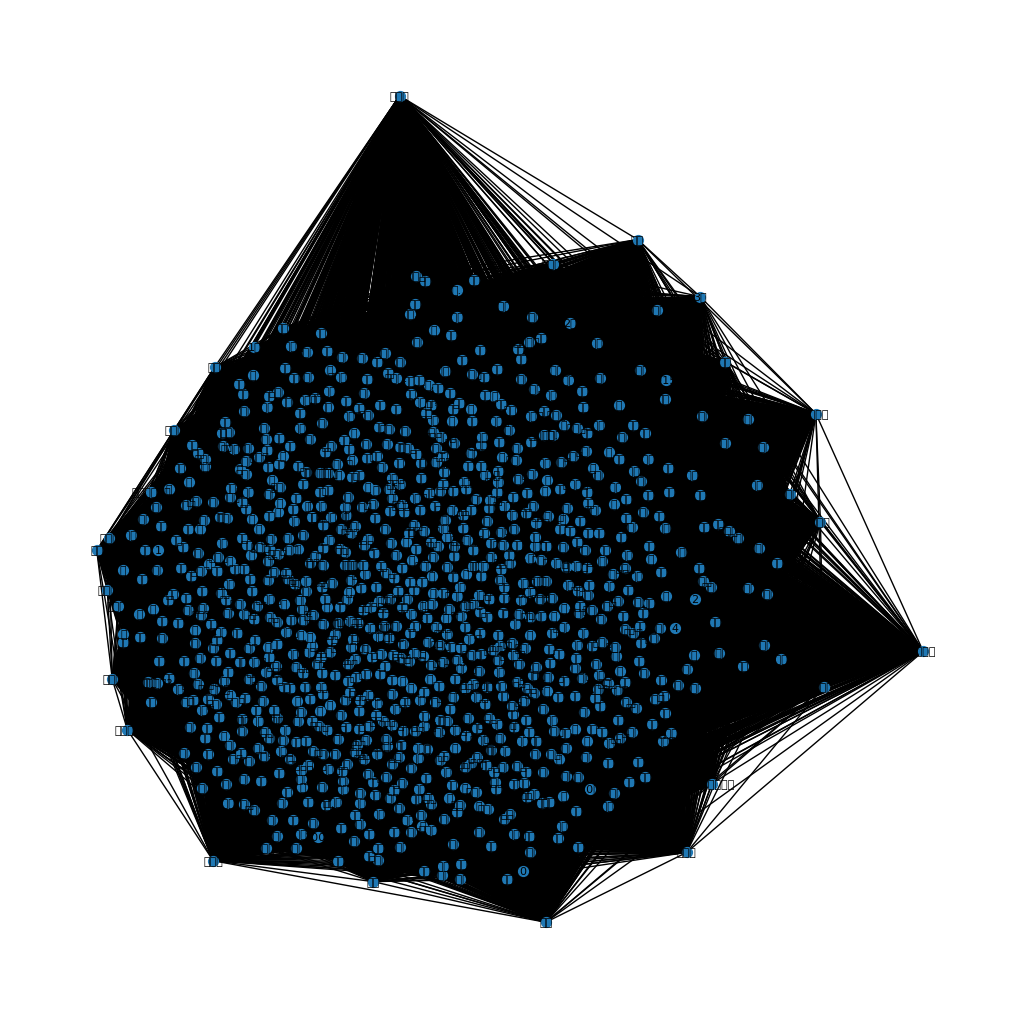

In [6]:
import networkx as nx
import numpy as np

# 토큰 리스트를 노드로 하는 그래프 생성
def build_graph(X, y):
    G = nx.Graph()
    
    for i, vector in enumerate(X):
        print(i)
        for token_index in np.where(vector > 0)[0]:
            token = vectorizer.get_feature_names_out()[token_index]
            G.add_node(token)
            for j in np.where(vector > 0)[0]:
                if j != token_index:
                    neighbor_token = vectorizer.get_feature_names_out()[j]
                    G.add_edge(token, neighbor_token, weight=vector[token_index] * vector[j])
    return G

# 그래프 생성
G = build_graph(X, y)

# 그래프 시각화
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G, k=0.1)
nx.draw(G, pos, with_labels=True, node_size=50, font_size=8)
plt.show()
plt.savefig('graph_visualization.png')

# 그래프 저장
nx.write_gml(G, 'token_graph.gml')

이 부분은 PyTorch Geometric을 사용하여 그래프 신경망(GNN)을 학습하고 다양한 성능 지표(Accuracy, Precision, Recall, F1 Score, Loss)를 평가 및 시각화하는 과정을 포함합니다. 다음은 각 단계에 대한 설명입니다:

1. **그래프 불러오기**:
   ```python
   G = nx.read_gml('token_graph.gml')
   ```
   - 'token_graph.gml' 파일에서 그래프 데이터를 불러옵니다.

2. **노드 이름을 인덱스로 변환**:
   ```python
   node_list = list(G.nodes)
   node_to_index = {node: i for i, node in enumerate(node_list)}
   ```
   - 그래프의 노드 리스트를 가져오고 각 노드를 인덱스로 매핑합니다.

3. **엣지를 숫자로 매핑하여 `edge_index` 생성**:
   ```python
   edge_index = torch.tensor([(node_to_index[edge[0]], node_to_index[edge[1]]) for edge in G.edges], dtype=torch.long).t().contiguous()
   ```
   - 엣지 정보를 숫자로 매핑하여 `torch.tensor` 형태로 변환합니다.

4. **데이터 로드**:
   ```python
   voicephishing_path = 'augmented_transcriptions.xlsx'
   ecommerce_path = 'combined_transcriptions.xlsx'

   voicephishing_data = pd.read_excel(voicephishing_path)
   ecommerce_data = pd.read_excel(ecommerce_path)
   ```
   - 음성 피싱 데이터와 전자상거래 데이터를 엑셀 파일에서 불러옵니다.

5. **데이터에 라벨 추가 및 데이터 합치기**:
   ```python
   voicephishing_data['label'] = 1
   ecommerce_data['label'] = 0

   combined_data = pd.concat([voicephishing_data, ecommerce_data.sample(n=3000, random_state=42)])
   ```
   - 음성 피싱 데이터에 라벨 1, 전자상거래 데이터에 라벨 0을 추가합니다.
   - 두 데이터를 합쳐서 사용합니다.

6. **'transcript' 열을 문자열로 변환 및 TF-IDF 벡터화**:
   ```python
   combined_data['transcript'] = combined_data['transcript'].astype(str)
   vectorizer = TfidfVectorizer(max_features=1000, tokenizer=lambda x: x.split())
   X = vectorizer.fit_transform(combined_data['transcript']).toarray()
   y = combined_data['label'].values
   ```
   - 텍스트 데이터를 문자열로 변환하고 TF-IDF를 사용하여 벡터화합니다.

7. **PyTorch 텐서로 변환**:
   ```python
   x = torch.tensor(X, dtype=torch.float)
   y = torch.tensor(y, dtype=torch.long)
   ```

8. **훈련, 검증, 테스트 마스크 설정**:
   ```python
   num_train = int(0.6 * len(y))
   num_val = int(0.2 * len(y))
   train_mask = torch.zeros(len(y), dtype=torch.bool)
   val_mask = torch.zeros(len(y), dtype=torch.bool)
   test_mask = torch.zeros(len(y), dtype=torch.bool)
   train_mask[:num_train] = True
   val_mask[num_train:num_train+num_val] = True
   test_mask[num_train+num_val:] = True
   ```
   - 데이터를 훈련, 검증, 테스트 세트로 나누고 각 세트에 대한 마스크를 설정합니다.

9. **PyTorch Geometric 데이터 객체 생성**:
   ```python
   data = Data(x=x, edge_index=edge_index, y=y)
   data.train_mask = train_mask
   data.val_mask = val_mask
   data.test_mask = test_mask
   ```

10. **그래프 신경망 모델 정의**:
    ```python
    class GNN(nn.Module):
        def __init__(self):
            super(GNN, self).__init__()
            self.conv1 = GCNConv(data.num_node_features, 16)
            self.conv2 = GCNConv(16, 2)
        
        def forward(self, data):
            x, edge_index = data.x, data.edge_index
            x = self.conv1(x, edge_index)
            x = torch.relu(x)
            x = self.conv2(x, edge_index)
            return torch.log_softmax(x, dim=1)
    ```
    - 두 개의 그래프 컨볼루션 레이어로 구성된 GNN 모델을 정의합니다.

11. **모델, 손실 함수, 최적화기 정의**:
    ```python
    model = GNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    ```

12. **훈련 및 평가 함수 정의**:
    ```python
    def train():
        model.train()
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        return loss.item()

    def evaluate(mask):
        model.eval()
        with torch.no_grad():
            out = model(data)
            loss = criterion(out[mask], data.y[mask]).item()
            _, pred = out[mask].max(dim=1)
            correct = pred.eq(data.y[mask]).sum().item()
            acc = correct / mask.sum().item()
            precision = precision_score(data.y[mask].cpu(), pred.cpu(), average='weighted')
            recall = recall_score(data.y[mask].cpu(), pred.cpu(), average='weighted')
            f1 = f1_score(data.y[mask].cpu(), pred.cpu(), average='weighted')
        return loss, acc, precision, recall, f1
    ```

13. **훈련 루프**:
    ```python
    num_epochs = 100
    for epoch in range(num_epochs):
        train_loss = train()
        val_loss, val_acc, val_precision, val_recall, val_f1 = evaluate(data.val_mask)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_acc, train_precision, train_recall, train_f1 = evaluate(data.train_mask)[1:]
        train_accuracies.append(train_acc)
        train_precisions.append(train_precision)
        train_recalls.append(train_recall)
        train_f1s.append(train_f1)
        val_accuracies.append(val_acc)
        val_precisions.append(val_precision)
        val_recalls.append(val_recall)
        val_f1s.append(val_f1)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}, Train Accuracy: {train_acc}, Val Accuracy: {val_acc}, Train Precision: {train_precision}, Val Precision: {val_precision}, Train Recall: {train_recall}, Val Recall: {val_recall}, Train F1: {train_f1}, Val F1: {val_f1}')
    ```

14. **성능 지표 곡선 저장**:
    ```python
    # 손실 곡선 저장
    plt.figure()
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()
    plt.savefig('loss_curve.png')

    # 정확도 곡선 저장
    plt.figure()
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()
    plt.savefig('accuracy_curve.png')

    # Precision 곡선 저장
    plt.figure()
    plt.plot(range(1, num_epochs + 1), train_precisions, label='Training Precision')
    plt.plot(range(1, num_epochs + 1), val_precisions, label='Validation Precision')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.title('Precision Curve')
    plt.legend()
    plt.savefig('precision_curve.png')

    # Recall 곡선 저장
    plt.figure()
    plt.plot(range(1, num_epochs + 1), train_recalls, label='Training Recall')
    plt.plot(range(1, num_epochs + 1), val_recalls, label='Validation Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.title('Recall Curve')
    plt.legend()
    plt.savefig('recall_curve.png')

    # F1 Score 곡선 저장
    plt.figure()
    plt.plot(range(1, num_epochs + 1), train_f1s, label='Training F1 Score')
    plt.plot(range(1, num_epochs + 1), val_f1s, label='Validation F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.title('F1 Score Curve')
    plt.legend()
    plt.savefig('f1_score_curve.png')
    ```

15. **테스트 정확도 평가 및 최종 모델 저장**:
    ```python
    test_loss, test_acc, test_precision, test_recall, test_f1 = evaluate(data.test_mask)
    print(f'Test Loss: {test_loss}, Test Accuracy: {test_acc}, Test Precision: {test_precision}, Test Recall: {test_recall}, Test

 F1 Score: {test_f1}')

    torch.save(model.state_dict(), 'gnn_model.pth')

    print(f'Final Training Loss: {train_losses[-1]}')
    print(f'Final Validation Loss: {val_losses[-1]}')
    print(f'Final Test Accuracy: {test_acc}')
    print(f'Final Test Precision: {test_precision}')
    print(f'Final Test Recall: {test_recall}')
    print(f'Final Test F1 Score: {test_f1}')
    ```

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, f1_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import networkx as nx
import numpy as np
import time
import matplotlib.pyplot as plt

C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1, Train Loss: 0.7011452913284302, Val Loss: 0.7006784081459045, Train Accuracy: 0.7381465517241379, Val Accuracy: 0.3739224137931034, Train Precision: 0.8187253460648316, Val Precision: 1.0, Train Recall: 0.7381465517241379, Val Recall: 0.3739224137931034, Train F1: 0.700732069196523, Val F1: 0.5443137254901961


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2, Train Loss: 0.5927713513374329, Val Loss: 0.6917299628257751, Train Accuracy: 0.8153735632183908, Val Accuracy: 0.5614224137931034, Train Precision: 0.8594301966936682, Val Precision: 1.0, Train Recall: 0.8153735632183908, Val Recall: 0.5614224137931034, Train F1: 0.8011329910590025, Val F1: 0.7191166321601105


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 3, Train Loss: 0.5006793737411499, Val Loss: 0.6660719513893127, Train Accuracy: 0.8789511494252874, Val Accuracy: 0.6928879310344828, Train Precision: 0.899585172006814, Val Precision: 1.0, Train Recall: 0.8789511494252874, Val Recall: 0.6928879310344828, Train F1: 0.8741357779694657, Val F1: 0.818586887332909


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 4, Train Loss: 0.4230877757072449, Val Loss: 0.6213291883468628, Train Accuracy: 0.9173850574712644, Val Accuracy: 0.790948275862069, Train Precision: 0.9275462536111623, Val Precision: 1.0, Train Recall: 0.9173850574712644, Val Recall: 0.790948275862069, Train F1: 0.915475333608104, Val F1: 0.8832731648616126


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 5, Train Loss: 0.36404284834861755, Val Loss: 0.5621068477630615, Train Accuracy: 0.9414511494252874, Val Accuracy: 0.8491379310344828, Train Precision: 0.9467442512797956, Val Precision: 1.0, Train Recall: 0.9414511494252874, Val Recall: 0.8491379310344828, Train F1: 0.9405915513480724, Val F1: 0.9184149184149184


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 6, Train Loss: 0.3157285153865814, Val Loss: 0.49475762248039246, Train Accuracy: 0.9619252873563219, Val Accuracy: 0.896551724137931, Train Precision: 0.9642368105752394, Val Precision: 1.0, Train Recall: 0.9619252873563219, Val Recall: 0.896551724137931, Train F1: 0.9615964377768517, Val F1: 0.9454545454545454


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 7, Train Loss: 0.2729571461677551, Val Loss: 0.4253159761428833, Train Accuracy: 0.9752155172413793, Val Accuracy: 0.9256465517241379, Train Precision: 0.9762161780432195, Val Precision: 1.0, Train Recall: 0.9752155172413793, Val Recall: 0.9256465517241379, Train F1: 0.9750854988020848, Val F1: 0.9613878007834359


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 8, Train Loss: 0.2341296374797821, Val Loss: 0.358661025762558, Train Accuracy: 0.9816810344827587, Val Accuracy: 0.9407327586206896, Train Precision: 0.9822335284161585, Val Precision: 1.0, Train Recall: 0.9816810344827587, Val Recall: 0.9407327586206896, Train F1: 0.981612451269185, Val F1: 0.9694614103275958


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 9, Train Loss: 0.19910882413387299, Val Loss: 0.2981676459312439, Train Accuracy: 0.985632183908046, Val Accuracy: 0.9461206896551724, Train Precision: 0.9859742747673781, Val Precision: 1.0, Train Recall: 0.985632183908046, Val Recall: 0.9461206896551724, Train F1: 0.9855909094717314, Val F1: 0.9723145071982281


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 10, Train Loss: 0.168269544839859, Val Loss: 0.24559372663497925, Train Accuracy: 0.9863505747126436, Val Accuracy: 0.9515086206896551, Train Precision: 0.9866596796953132, Val Precision: 1.0, Train Recall: 0.9863505747126436, Val Recall: 0.9515086206896551, Train F1: 0.9863134741650673, Val F1: 0.9751518498067366


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 11, Train Loss: 0.14180254936218262, Val Loss: 0.20158220827579498, Train Accuracy: 0.9867097701149425, Val Accuracy: 0.9536637931034483, Train Precision: 0.9870029952227225, Val Precision: 1.0, Train Recall: 0.9867097701149425, Val Recall: 0.9536637931034483, Train F1: 0.9866746674200142, Val F1: 0.9762824048538334


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 12, Train Loss: 0.11954953521490097, Val Loss: 0.1657434105873108, Train Accuracy: 0.9874281609195402, Val Accuracy: 0.9568965517241379, Train Precision: 0.9876908560645051, Val Precision: 1.0, Train Recall: 0.9874281609195402, Val Recall: 0.9568965517241379, Train F1: 0.9873968773245735, Val F1: 0.9779735682819384


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 13, Train Loss: 0.10111509263515472, Val Loss: 0.13719385862350464, Train Accuracy: 0.9877873563218391, Val Accuracy: 0.9579741379310345, Train Precision: 0.9880354028481577, Val Precision: 1.0, Train Recall: 0.9877873563218391, Val Recall: 0.9579741379310345, Train F1: 0.9877578946046048, Val F1: 0.9785360484314805


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 14, Train Loss: 0.08599500358104706, Val Loss: 0.11483554542064667, Train Accuracy: 0.9881465517241379, Val Accuracy: 0.959051724137931, Train Precision: 0.9883803615227653, Val Precision: 1.0, Train Recall: 0.9881465517241379, Val Recall: 0.959051724137931, Train F1: 0.9881188538562947, Val F1: 0.9790979097909791


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 15, Train Loss: 0.07361109554767609, Val Loss: 0.0975242555141449, Train Accuracy: 0.9881465517241379, Val Accuracy: 0.959051724137931, Train Precision: 0.9883803615227653, Val Precision: 1.0, Train Recall: 0.9881465517241379, Val Recall: 0.959051724137931, Train F1: 0.9881188538562947, Val F1: 0.9790979097909791


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 16, Train Loss: 0.06344074755907059, Val Loss: 0.0842062383890152, Train Accuracy: 0.9985632183908046, Val Accuracy: 0.9978448275862069, Train Precision: 0.9985682245985021, Val Precision: 1.0, Train Recall: 0.9985632183908046, Val Recall: 0.9978448275862069, Train F1: 0.9985635949708889, Val F1: 0.9989212513484358


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 17, Train Loss: 0.05504264682531357, Val Loss: 0.07399250566959381, Train Accuracy: 0.9985632183908046, Val Accuracy: 0.9989224137931034, Train Precision: 0.9985682245985021, Val Precision: 1.0, Train Recall: 0.9985632183908046, Val Recall: 0.9989224137931034, Train F1: 0.9985635949708889, Val F1: 0.9994609164420484


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 18, Train Loss: 0.04807513952255249, Val Loss: 0.0661553293466568, Train Accuracy: 0.9985632183908046, Val Accuracy: 0.9989224137931034, Train Precision: 0.9985682245985021, Val Precision: 1.0, Train Recall: 0.9985632183908046, Val Recall: 0.9989224137931034, Train F1: 0.9985635949708889, Val F1: 0.9994609164420484


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 19, Train Loss: 0.042268261313438416, Val Loss: 0.06012272462248802, Train Accuracy: 0.9985632183908046, Val Accuracy: 0.9989224137931034, Train Precision: 0.9985682245985021, Val Precision: 1.0, Train Recall: 0.9985632183908046, Val Recall: 0.9989224137931034, Train F1: 0.9985635949708889, Val F1: 0.9994609164420484


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 20, Train Loss: 0.03741760179400444, Val Loss: 0.055453572422266006, Train Accuracy: 0.9985632183908046, Val Accuracy: 0.9989224137931034, Train Precision: 0.9985682245985021, Val Precision: 1.0, Train Recall: 0.9985632183908046, Val Recall: 0.9989224137931034, Train F1: 0.9985635949708889, Val F1: 0.9994609164420484


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 21, Train Loss: 0.03336465358734131, Val Loss: 0.05181187018752098, Train Accuracy: 0.9985632183908046, Val Accuracy: 0.9989224137931034, Train Precision: 0.9985682245985021, Val Precision: 1.0, Train Recall: 0.9985632183908046, Val Recall: 0.9989224137931034, Train F1: 0.9985635949708889, Val F1: 0.9994609164420484


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 22, Train Loss: 0.02997962385416031, Val Loss: 0.048943206667900085, Train Accuracy: 0.9985632183908046, Val Accuracy: 0.9989224137931034, Train Precision: 0.9985682245985021, Val Precision: 1.0, Train Recall: 0.9985632183908046, Val Recall: 0.9989224137931034, Train F1: 0.9985635949708889, Val F1: 0.9994609164420484


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 23, Train Loss: 0.027153996750712395, Val Loss: 0.04665602743625641, Train Accuracy: 0.9985632183908046, Val Accuracy: 0.9989224137931034, Train Precision: 0.9985682245985021, Val Precision: 1.0, Train Recall: 0.9985632183908046, Val Recall: 0.9989224137931034, Train F1: 0.9985635949708889, Val F1: 0.9994609164420484


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 24, Train Loss: 0.024795211851596832, Val Loss: 0.04480455815792084, Train Accuracy: 0.9985632183908046, Val Accuracy: 0.9989224137931034, Train Precision: 0.9985682245985021, Val Precision: 1.0, Train Recall: 0.9985632183908046, Val Recall: 0.9989224137931034, Train F1: 0.9985635949708889, Val F1: 0.9994609164420484


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 25, Train Loss: 0.022824591025710106, Val Loss: 0.04327758401632309, Train Accuracy: 0.9985632183908046, Val Accuracy: 0.9989224137931034, Train Precision: 0.9985682245985021, Val Precision: 1.0, Train Recall: 0.9985632183908046, Val Recall: 0.9989224137931034, Train F1: 0.9985635949708889, Val F1: 0.9994609164420484


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 26, Train Loss: 0.021173935383558273, Val Loss: 0.04199099540710449, Train Accuracy: 0.9985632183908046, Val Accuracy: 0.9989224137931034, Train Precision: 0.9985682245985021, Val Precision: 1.0, Train Recall: 0.9985632183908046, Val Recall: 0.9989224137931034, Train F1: 0.9985635949708889, Val F1: 0.9994609164420484


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 27, Train Loss: 0.019785556942224503, Val Loss: 0.04088105261325836, Train Accuracy: 0.9985632183908046, Val Accuracy: 0.9989224137931034, Train Precision: 0.9985682245985021, Val Precision: 1.0, Train Recall: 0.9985632183908046, Val Recall: 0.9989224137931034, Train F1: 0.9985635949708889, Val F1: 0.9994609164420484


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 28, Train Loss: 0.018610790371894836, Val Loss: 0.03989792987704277, Train Accuracy: 0.9985632183908046, Val Accuracy: 0.9989224137931034, Train Precision: 0.9985682245985021, Val Precision: 1.0, Train Recall: 0.9985632183908046, Val Recall: 0.9989224137931034, Train F1: 0.9985635949708889, Val F1: 0.9994609164420484


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 29, Train Loss: 0.017608877271413803, Val Loss: 0.03900447487831116, Train Accuracy: 0.9985632183908046, Val Accuracy: 0.9989224137931034, Train Precision: 0.9985682245985021, Val Precision: 1.0, Train Recall: 0.9985632183908046, Val Recall: 0.9989224137931034, Train F1: 0.9985635949708889, Val F1: 0.9994609164420484


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 30, Train Loss: 0.016746804118156433, Val Loss: 0.03817293047904968, Train Accuracy: 0.9985632183908046, Val Accuracy: 0.9989224137931034, Train Precision: 0.9985682245985021, Val Precision: 1.0, Train Recall: 0.9985632183908046, Val Recall: 0.9989224137931034, Train F1: 0.9985635949708889, Val F1: 0.9994609164420484


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 31, Train Loss: 0.015997786074876785, Val Loss: 0.037382736802101135, Train Accuracy: 0.9985632183908046, Val Accuracy: 0.9989224137931034, Train Precision: 0.9985682245985021, Val Precision: 1.0, Train Recall: 0.9985632183908046, Val Recall: 0.9989224137931034, Train F1: 0.9985635949708889, Val F1: 0.9994609164420484


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 32, Train Loss: 0.015340670943260193, Val Loss: 0.036618784070014954, Train Accuracy: 0.9985632183908046, Val Accuracy: 0.9989224137931034, Train Precision: 0.9985682245985021, Val Precision: 1.0, Train Recall: 0.9985632183908046, Val Recall: 0.9989224137931034, Train F1: 0.9985635949708889, Val F1: 0.9994609164420484


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 33, Train Loss: 0.014758049510419369, Val Loss: 0.03587072342634201, Train Accuracy: 0.9985632183908046, Val Accuracy: 0.9989224137931034, Train Precision: 0.9985682245985021, Val Precision: 1.0, Train Recall: 0.9985632183908046, Val Recall: 0.9989224137931034, Train F1: 0.9985635949708889, Val F1: 0.9994609164420484


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 34, Train Loss: 0.014236127957701683, Val Loss: 0.03513123095035553, Train Accuracy: 0.9985632183908046, Val Accuracy: 0.9989224137931034, Train Precision: 0.9985682245985021, Val Precision: 1.0, Train Recall: 0.9985632183908046, Val Recall: 0.9989224137931034, Train F1: 0.9985635949708889, Val F1: 0.9994609164420484


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 35, Train Loss: 0.013764095492661, Val Loss: 0.03439575806260109, Train Accuracy: 0.9985632183908046, Val Accuracy: 0.9989224137931034, Train Precision: 0.9985682245985021, Val Precision: 1.0, Train Recall: 0.9985632183908046, Val Recall: 0.9989224137931034, Train F1: 0.9985635949708889, Val F1: 0.9994609164420484


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 36, Train Loss: 0.013333382084965706, Val Loss: 0.033662088215351105, Train Accuracy: 0.9985632183908046, Val Accuracy: 0.9989224137931034, Train Precision: 0.9985682245985021, Val Precision: 1.0, Train Recall: 0.9985632183908046, Val Recall: 0.9989224137931034, Train F1: 0.9985635949708889, Val F1: 0.9994609164420484


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 37, Train Loss: 0.01293717697262764, Val Loss: 0.032929010689258575, Train Accuracy: 0.9985632183908046, Val Accuracy: 0.9989224137931034, Train Precision: 0.9985682245985021, Val Precision: 1.0, Train Recall: 0.9985632183908046, Val Recall: 0.9989224137931034, Train F1: 0.9985635949708889, Val F1: 0.9994609164420484


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 38, Train Loss: 0.012570405378937721, Val Loss: 0.03219633921980858, Train Accuracy: 0.9985632183908046, Val Accuracy: 0.9989224137931034, Train Precision: 0.9985682245985021, Val Precision: 1.0, Train Recall: 0.9985632183908046, Val Recall: 0.9989224137931034, Train F1: 0.9985635949708889, Val F1: 0.9994609164420484


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 39, Train Loss: 0.012229029089212418, Val Loss: 0.03146497905254364, Train Accuracy: 0.9985632183908046, Val Accuracy: 0.9989224137931034, Train Precision: 0.9985682245985021, Val Precision: 1.0, Train Recall: 0.9985632183908046, Val Recall: 0.9989224137931034, Train F1: 0.9985635949708889, Val F1: 0.9994609164420484


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 40, Train Loss: 0.011909746564924717, Val Loss: 0.030736230313777924, Train Accuracy: 0.9985632183908046, Val Accuracy: 0.9989224137931034, Train Precision: 0.9985682245985021, Val Precision: 1.0, Train Recall: 0.9985632183908046, Val Recall: 0.9989224137931034, Train F1: 0.9985635949708889, Val F1: 0.9994609164420484


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 41, Train Loss: 0.011609830893576145, Val Loss: 0.030011868104338646, Train Accuracy: 0.9985632183908046, Val Accuracy: 0.9989224137931034, Train Precision: 0.9985682245985021, Val Precision: 1.0, Train Recall: 0.9985632183908046, Val Recall: 0.9989224137931034, Train F1: 0.9985635949708889, Val F1: 0.9994609164420484


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 42, Train Loss: 0.011327176354825497, Val Loss: 0.029293565079569817, Train Accuracy: 0.9985632183908046, Val Accuracy: 0.9989224137931034, Train Precision: 0.9985682245985021, Val Precision: 1.0, Train Recall: 0.9985632183908046, Val Recall: 0.9989224137931034, Train F1: 0.9985635949708889, Val F1: 0.9994609164420484


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 43, Train Loss: 0.011060143820941448, Val Loss: 0.028583213686943054, Train Accuracy: 0.9985632183908046, Val Accuracy: 0.9989224137931034, Train Precision: 0.9985682245985021, Val Precision: 1.0, Train Recall: 0.9985632183908046, Val Recall: 0.9989224137931034, Train F1: 0.9985635949708889, Val F1: 0.9994609164420484


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 44, Train Loss: 0.01080735120922327, Val Loss: 0.027882514521479607, Train Accuracy: 0.9985632183908046, Val Accuracy: 0.9989224137931034, Train Precision: 0.9985682245985021, Val Precision: 1.0, Train Recall: 0.9985632183908046, Val Recall: 0.9989224137931034, Train F1: 0.9985635949708889, Val F1: 0.9994609164420484


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 45, Train Loss: 0.010567741468548775, Val Loss: 0.02719302847981453, Train Accuracy: 0.9985632183908046, Val Accuracy: 0.9989224137931034, Train Precision: 0.9985682245985021, Val Precision: 1.0, Train Recall: 0.9985632183908046, Val Recall: 0.9989224137931034, Train F1: 0.9985635949708889, Val F1: 0.9994609164420484


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 46, Train Loss: 0.010340317152440548, Val Loss: 0.02651648409664631, Train Accuracy: 0.9985632183908046, Val Accuracy: 0.9989224137931034, Train Precision: 0.9985682245985021, Val Precision: 1.0, Train Recall: 0.9985632183908046, Val Recall: 0.9989224137931034, Train F1: 0.9985635949708889, Val F1: 0.9994609164420484


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 47, Train Loss: 0.010124363005161285, Val Loss: 0.025854216888546944, Train Accuracy: 0.9985632183908046, Val Accuracy: 0.9989224137931034, Train Precision: 0.9985682245985021, Val Precision: 1.0, Train Recall: 0.9985632183908046, Val Recall: 0.9989224137931034, Train F1: 0.9985635949708889, Val F1: 0.9994609164420484


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 48, Train Loss: 0.009919175878167152, Val Loss: 0.025207381695508957, Train Accuracy: 0.9985632183908046, Val Accuracy: 0.9989224137931034, Train Precision: 0.9985682245985021, Val Precision: 1.0, Train Recall: 0.9985632183908046, Val Recall: 0.9989224137931034, Train F1: 0.9985635949708889, Val F1: 0.9994609164420484


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 49, Train Loss: 0.009724055416882038, Val Loss: 0.024577006697654724, Train Accuracy: 0.9985632183908046, Val Accuracy: 0.9989224137931034, Train Precision: 0.9985682245985021, Val Precision: 1.0, Train Recall: 0.9985632183908046, Val Recall: 0.9989224137931034, Train F1: 0.9985635949708889, Val F1: 0.9994609164420484


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 50, Train Loss: 0.009538444690406322, Val Loss: 0.023963991552591324, Train Accuracy: 0.9985632183908046, Val Accuracy: 0.9989224137931034, Train Precision: 0.9985682245985021, Val Precision: 1.0, Train Recall: 0.9985632183908046, Val Recall: 0.9989224137931034, Train F1: 0.9985635949708889, Val F1: 0.9994609164420484


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 51, Train Loss: 0.009361807256937027, Val Loss: 0.023368921130895615, Train Accuracy: 0.9985632183908046, Val Accuracy: 0.9989224137931034, Train Precision: 0.9985682245985021, Val Precision: 1.0, Train Recall: 0.9985632183908046, Val Recall: 0.9989224137931034, Train F1: 0.9985635949708889, Val F1: 0.9994609164420484


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 52, Train Loss: 0.009193770587444305, Val Loss: 0.022792555391788483, Train Accuracy: 0.9985632183908046, Val Accuracy: 0.9989224137931034, Train Precision: 0.9985682245985021, Val Precision: 1.0, Train Recall: 0.9985632183908046, Val Recall: 0.9989224137931034, Train F1: 0.9985635949708889, Val F1: 0.9994609164420484


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 53, Train Loss: 0.009033801034092903, Val Loss: 0.02223498746752739, Train Accuracy: 0.9985632183908046, Val Accuracy: 0.9989224137931034, Train Precision: 0.9985682245985021, Val Precision: 1.0, Train Recall: 0.9985632183908046, Val Recall: 0.9989224137931034, Train F1: 0.9985635949708889, Val F1: 0.9994609164420484


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 54, Train Loss: 0.008881347253918648, Val Loss: 0.021696532145142555, Train Accuracy: 0.9985632183908046, Val Accuracy: 0.9989224137931034, Train Precision: 0.9985682245985021, Val Precision: 1.0, Train Recall: 0.9985632183908046, Val Recall: 0.9989224137931034, Train F1: 0.9985635949708889, Val F1: 0.9994609164420484


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 55, Train Loss: 0.00873600784689188, Val Loss: 0.021177135407924652, Train Accuracy: 0.9985632183908046, Val Accuracy: 0.9989224137931034, Train Precision: 0.9985682245985021, Val Precision: 1.0, Train Recall: 0.9985632183908046, Val Recall: 0.9989224137931034, Train F1: 0.9985635949708889, Val F1: 0.9994609164420484


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 56, Train Loss: 0.008597476407885551, Val Loss: 0.020676614716649055, Train Accuracy: 0.9985632183908046, Val Accuracy: 0.9989224137931034, Train Precision: 0.9985682245985021, Val Precision: 1.0, Train Recall: 0.9985632183908046, Val Recall: 0.9989224137931034, Train F1: 0.9985635949708889, Val F1: 0.9994609164420484


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 57, Train Loss: 0.008465313352644444, Val Loss: 0.020194901153445244, Train Accuracy: 0.9985632183908046, Val Accuracy: 0.9989224137931034, Train Precision: 0.9985682245985021, Val Precision: 1.0, Train Recall: 0.9985632183908046, Val Recall: 0.9989224137931034, Train F1: 0.9985635949708889, Val F1: 0.9994609164420484


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 58, Train Loss: 0.008339117281138897, Val Loss: 0.019731735810637474, Train Accuracy: 0.9985632183908046, Val Accuracy: 0.9989224137931034, Train Precision: 0.9985682245985021, Val Precision: 1.0, Train Recall: 0.9985632183908046, Val Recall: 0.9989224137931034, Train F1: 0.9985635949708889, Val F1: 0.9994609164420484


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 59, Train Loss: 0.008218558505177498, Val Loss: 0.01928677409887314, Train Accuracy: 0.9985632183908046, Val Accuracy: 0.9989224137931034, Train Precision: 0.9985682245985021, Val Precision: 1.0, Train Recall: 0.9985632183908046, Val Recall: 0.9989224137931034, Train F1: 0.9985635949708889, Val F1: 0.9994609164420484


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 60, Train Loss: 0.008103294298052788, Val Loss: 0.018859663978219032, Train Accuracy: 0.9985632183908046, Val Accuracy: 0.9989224137931034, Train Precision: 0.9985682245985021, Val Precision: 1.0, Train Recall: 0.9985632183908046, Val Recall: 0.9989224137931034, Train F1: 0.9985635949708889, Val F1: 0.9994609164420484


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 61, Train Loss: 0.007993025705218315, Val Loss: 0.018449999392032623, Train Accuracy: 0.9985632183908046, Val Accuracy: 0.9989224137931034, Train Precision: 0.9985682245985021, Val Precision: 1.0, Train Recall: 0.9985632183908046, Val Recall: 0.9989224137931034, Train F1: 0.9985635949708889, Val F1: 0.9994609164420484


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 62, Train Loss: 0.00788748636841774, Val Loss: 0.01806071773171425, Train Accuracy: 0.9985632183908046, Val Accuracy: 0.9989224137931034, Train Precision: 0.9985682245985021, Val Precision: 1.0, Train Recall: 0.9985632183908046, Val Recall: 0.9989224137931034, Train F1: 0.9985635949708889, Val F1: 0.9994609164420484


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 63, Train Loss: 0.007787176873534918, Val Loss: 0.017725693061947823, Train Accuracy: 0.9985632183908046, Val Accuracy: 0.9989224137931034, Train Precision: 0.9985682245985021, Val Precision: 1.0, Train Recall: 0.9985632183908046, Val Recall: 0.9989224137931034, Train F1: 0.9985635949708889, Val F1: 0.9994609164420484


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 64, Train Loss: 0.007698702625930309, Val Loss: 0.017405463382601738, Train Accuracy: 0.9985632183908046, Val Accuracy: 0.9989224137931034, Train Precision: 0.9985682245985021, Val Precision: 1.0, Train Recall: 0.9985632183908046, Val Recall: 0.9989224137931034, Train F1: 0.9985635949708889, Val F1: 0.9994609164420484


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 65, Train Loss: 0.007613291498273611, Val Loss: 0.01709921471774578, Train Accuracy: 0.9985632183908046, Val Accuracy: 0.9989224137931034, Train Precision: 0.9985682245985021, Val Precision: 1.0, Train Recall: 0.9985632183908046, Val Recall: 0.9989224137931034, Train F1: 0.9985635949708889, Val F1: 0.9994609164420484


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 66, Train Loss: 0.007530740462243557, Val Loss: 0.01680624857544899, Train Accuracy: 0.9985632183908046, Val Accuracy: 0.9989224137931034, Train Precision: 0.9985682245985021, Val Precision: 1.0, Train Recall: 0.9985632183908046, Val Recall: 0.9989224137931034, Train F1: 0.9985635949708889, Val F1: 0.9994609164420484


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 67, Train Loss: 0.007450883276760578, Val Loss: 0.016525836661458015, Train Accuracy: 0.9985632183908046, Val Accuracy: 0.9989224137931034, Train Precision: 0.9985682245985021, Val Precision: 1.0, Train Recall: 0.9985632183908046, Val Recall: 0.9989224137931034, Train F1: 0.9985635949708889, Val F1: 0.9994609164420484


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 68, Train Loss: 0.007373652886599302, Val Loss: 0.016257233917713165, Train Accuracy: 0.9985632183908046, Val Accuracy: 0.9989224137931034, Train Precision: 0.9985682245985021, Val Precision: 1.0, Train Recall: 0.9985632183908046, Val Recall: 0.9989224137931034, Train F1: 0.9985635949708889, Val F1: 0.9994609164420484


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 69, Train Loss: 0.007298888172954321, Val Loss: 0.01599980518221855, Train Accuracy: 0.9985632183908046, Val Accuracy: 0.9989224137931034, Train Precision: 0.9985682245985021, Val Precision: 1.0, Train Recall: 0.9985632183908046, Val Recall: 0.9989224137931034, Train F1: 0.9985635949708889, Val F1: 0.9994609164420484


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 70, Train Loss: 0.007226484827697277, Val Loss: 0.015752920880913734, Train Accuracy: 0.9985632183908046, Val Accuracy: 0.9989224137931034, Train Precision: 0.9985682245985021, Val Precision: 1.0, Train Recall: 0.9985632183908046, Val Recall: 0.9989224137931034, Train F1: 0.9985635949708889, Val F1: 0.9994609164420484


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 71, Train Loss: 0.007156347390264273, Val Loss: 0.015516070649027824, Train Accuracy: 0.9985632183908046, Val Accuracy: 0.9989224137931034, Train Precision: 0.9985682245985021, Val Precision: 1.0, Train Recall: 0.9985632183908046, Val Recall: 0.9989224137931034, Train F1: 0.9985635949708889, Val F1: 0.9994609164420484


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 72, Train Loss: 0.0070884376764297485, Val Loss: 0.01528856996446848, Train Accuracy: 0.9985632183908046, Val Accuracy: 0.9989224137931034, Train Precision: 0.9985682245985021, Val Precision: 1.0, Train Recall: 0.9985632183908046, Val Recall: 0.9989224137931034, Train F1: 0.9985635949708889, Val F1: 0.9994609164420484


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 73, Train Loss: 0.007022671401500702, Val Loss: 0.015069865621626377, Train Accuracy: 0.9985632183908046, Val Accuracy: 0.9989224137931034, Train Precision: 0.9985682245985021, Val Precision: 1.0, Train Recall: 0.9985632183908046, Val Recall: 0.9989224137931034, Train F1: 0.9985635949708889, Val F1: 0.9994609164420484


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 74, Train Loss: 0.006958945654332638, Val Loss: 0.014859439805150032, Train Accuracy: 0.9985632183908046, Val Accuracy: 0.9989224137931034, Train Precision: 0.9985682245985021, Val Precision: 1.0, Train Recall: 0.9985632183908046, Val Recall: 0.9989224137931034, Train F1: 0.9985635949708889, Val F1: 0.9994609164420484


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 75, Train Loss: 0.006897209212183952, Val Loss: 0.01465682964771986, Train Accuracy: 0.9985632183908046, Val Accuracy: 0.9989224137931034, Train Precision: 0.9985682245985021, Val Precision: 1.0, Train Recall: 0.9985632183908046, Val Recall: 0.9989224137931034, Train F1: 0.9985635949708889, Val F1: 0.9994609164420484


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 76, Train Loss: 0.006837381049990654, Val Loss: 0.014461573213338852, Train Accuracy: 0.9985632183908046, Val Accuracy: 0.9989224137931034, Train Precision: 0.9985682245985021, Val Precision: 1.0, Train Recall: 0.9985632183908046, Val Recall: 0.9989224137931034, Train F1: 0.9985635949708889, Val F1: 0.9994609164420484


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 77, Train Loss: 0.006779433693736792, Val Loss: 0.014273199252784252, Train Accuracy: 0.9985632183908046, Val Accuracy: 0.9989224137931034, Train Precision: 0.9985682245985021, Val Precision: 1.0, Train Recall: 0.9985632183908046, Val Recall: 0.9989224137931034, Train F1: 0.9985635949708889, Val F1: 0.9994609164420484


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 78, Train Loss: 0.006723278667777777, Val Loss: 0.01409133430570364, Train Accuracy: 0.9985632183908046, Val Accuracy: 0.9989224137931034, Train Precision: 0.9985682245985021, Val Precision: 1.0, Train Recall: 0.9985632183908046, Val Recall: 0.9989224137931034, Train F1: 0.9985635949708889, Val F1: 0.9994609164420484


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 79, Train Loss: 0.00666884845122695, Val Loss: 0.013915625400841236, Train Accuracy: 0.9985632183908046, Val Accuracy: 0.9989224137931034, Train Precision: 0.9985682245985021, Val Precision: 1.0, Train Recall: 0.9985632183908046, Val Recall: 0.9989224137931034, Train F1: 0.9985635949708889, Val F1: 0.9994609164420484


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 80, Train Loss: 0.0066161067225039005, Val Loss: 0.013745688833296299, Train Accuracy: 0.9985632183908046, Val Accuracy: 0.9989224137931034, Train Precision: 0.9985682245985021, Val Precision: 1.0, Train Recall: 0.9985632183908046, Val Recall: 0.9989224137931034, Train F1: 0.9985635949708889, Val F1: 0.9994609164420484


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 81, Train Loss: 0.006565004121512175, Val Loss: 0.01358118373900652, Train Accuracy: 0.9985632183908046, Val Accuracy: 0.9989224137931034, Train Precision: 0.9985682245985021, Val Precision: 1.0, Train Recall: 0.9985632183908046, Val Recall: 0.9989224137931034, Train F1: 0.9985635949708889, Val F1: 0.9994609164420484


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 82, Train Loss: 0.006515476852655411, Val Loss: 0.013421823270618916, Train Accuracy: 0.9985632183908046, Val Accuracy: 0.9989224137931034, Train Precision: 0.9985682245985021, Val Precision: 1.0, Train Recall: 0.9985632183908046, Val Recall: 0.9989224137931034, Train F1: 0.9985635949708889, Val F1: 0.9994609164420484


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 83, Train Loss: 0.006467476021498442, Val Loss: 0.013267370872199535, Train Accuracy: 0.9985632183908046, Val Accuracy: 0.9989224137931034, Train Precision: 0.9985682245985021, Val Precision: 1.0, Train Recall: 0.9985632183908046, Val Recall: 0.9989224137931034, Train F1: 0.9985635949708889, Val F1: 0.9994609164420484


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 84, Train Loss: 0.006420958787202835, Val Loss: 0.013117542490363121, Train Accuracy: 0.9985632183908046, Val Accuracy: 0.9989224137931034, Train Precision: 0.9985682245985021, Val Precision: 1.0, Train Recall: 0.9985632183908046, Val Recall: 0.9989224137931034, Train F1: 0.9985635949708889, Val F1: 0.9994609164420484


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 85, Train Loss: 0.006375906988978386, Val Loss: 0.012972118332982063, Train Accuracy: 0.9985632183908046, Val Accuracy: 0.9989224137931034, Train Precision: 0.9985682245985021, Val Precision: 1.0, Train Recall: 0.9985632183908046, Val Recall: 0.9989224137931034, Train F1: 0.9985635949708889, Val F1: 0.9994609164420484


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 86, Train Loss: 0.006332276854664087, Val Loss: 0.012830883264541626, Train Accuracy: 0.9985632183908046, Val Accuracy: 0.9989224137931034, Train Precision: 0.9985682245985021, Val Precision: 1.0, Train Recall: 0.9985632183908046, Val Recall: 0.9989224137931034, Train F1: 0.9985635949708889, Val F1: 0.9994609164420484


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 87, Train Loss: 0.006290003657341003, Val Loss: 0.012693626806139946, Train Accuracy: 0.9985632183908046, Val Accuracy: 0.9989224137931034, Train Precision: 0.9985682245985021, Val Precision: 1.0, Train Recall: 0.9985632183908046, Val Recall: 0.9989224137931034, Train F1: 0.9985635949708889, Val F1: 0.9994609164420484


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 88, Train Loss: 0.006249055732041597, Val Loss: 0.012560155242681503, Train Accuracy: 0.9985632183908046, Val Accuracy: 0.9989224137931034, Train Precision: 0.9985682245985021, Val Precision: 1.0, Train Recall: 0.9985632183908046, Val Recall: 0.9989224137931034, Train F1: 0.9985635949708889, Val F1: 0.9994609164420484


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 89, Train Loss: 0.006209374871104956, Val Loss: 0.012430262751877308, Train Accuracy: 0.9985632183908046, Val Accuracy: 0.9989224137931034, Train Precision: 0.9985682245985021, Val Precision: 1.0, Train Recall: 0.9985632183908046, Val Recall: 0.9989224137931034, Train F1: 0.9985635949708889, Val F1: 0.9994609164420484


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 90, Train Loss: 0.006170920096337795, Val Loss: 0.012303757481276989, Train Accuracy: 0.9985632183908046, Val Accuracy: 0.9989224137931034, Train Precision: 0.9985682245985021, Val Precision: 1.0, Train Recall: 0.9985632183908046, Val Recall: 0.9989224137931034, Train F1: 0.9985635949708889, Val F1: 0.9994609164420484


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 91, Train Loss: 0.006133691407740116, Val Loss: 0.012180537916719913, Train Accuracy: 0.9985632183908046, Val Accuracy: 0.9989224137931034, Train Precision: 0.9985682245985021, Val Precision: 1.0, Train Recall: 0.9985632183908046, Val Recall: 0.9989224137931034, Train F1: 0.9985635949708889, Val F1: 0.9994609164420484


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 92, Train Loss: 0.006097631063312292, Val Loss: 0.012060469016432762, Train Accuracy: 0.9985632183908046, Val Accuracy: 0.9989224137931034, Train Precision: 0.9985682245985021, Val Precision: 1.0, Train Recall: 0.9985632183908046, Val Recall: 0.9989224137931034, Train F1: 0.9985635949708889, Val F1: 0.9994609164420484


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 93, Train Loss: 0.006062686908990145, Val Loss: 0.011943542398512363, Train Accuracy: 0.9985632183908046, Val Accuracy: 0.9989224137931034, Train Precision: 0.9985682245985021, Val Precision: 1.0, Train Recall: 0.9985632183908046, Val Recall: 0.9989224137931034, Train F1: 0.9985635949708889, Val F1: 0.9994609164420484


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 94, Train Loss: 0.006028832867741585, Val Loss: 0.011836112476885319, Train Accuracy: 0.9985632183908046, Val Accuracy: 0.9989224137931034, Train Precision: 0.9985682245985021, Val Precision: 1.0, Train Recall: 0.9985632183908046, Val Recall: 0.9989224137931034, Train F1: 0.9985635949708889, Val F1: 0.9994609164420484


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 95, Train Loss: 0.005997306201606989, Val Loss: 0.011728690005838871, Train Accuracy: 0.9985632183908046, Val Accuracy: 0.9989224137931034, Train Precision: 0.9985682245985021, Val Precision: 1.0, Train Recall: 0.9985632183908046, Val Recall: 0.9989224137931034, Train F1: 0.9985635949708889, Val F1: 0.9994609164420484


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 96, Train Loss: 0.0059665474109351635, Val Loss: 0.011621501296758652, Train Accuracy: 0.9985632183908046, Val Accuracy: 0.9989224137931034, Train Precision: 0.9985682245985021, Val Precision: 1.0, Train Recall: 0.9985632183908046, Val Recall: 0.9989224137931034, Train F1: 0.9985635949708889, Val F1: 0.9994609164420484


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 97, Train Loss: 0.005936556961387396, Val Loss: 0.011514689773321152, Train Accuracy: 0.9985632183908046, Val Accuracy: 0.9989224137931034, Train Precision: 0.9985682245985021, Val Precision: 1.0, Train Recall: 0.9985632183908046, Val Recall: 0.9989224137931034, Train F1: 0.9985635949708889, Val F1: 0.9994609164420484


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 98, Train Loss: 0.005907333921641111, Val Loss: 0.011408437974750996, Train Accuracy: 0.9985632183908046, Val Accuracy: 0.9989224137931034, Train Precision: 0.9985682245985021, Val Precision: 1.0, Train Recall: 0.9985632183908046, Val Recall: 0.9989224137931034, Train F1: 0.9985635949708889, Val F1: 0.9994609164420484


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 99, Train Loss: 0.005878854542970657, Val Loss: 0.011302927508950233, Train Accuracy: 0.9985632183908046, Val Accuracy: 0.9989224137931034, Train Precision: 0.9985682245985021, Val Precision: 1.0, Train Recall: 0.9985632183908046, Val Recall: 0.9989224137931034, Train F1: 0.9985635949708889, Val F1: 0.9994609164420484


C:\Users\kimhw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 100, Train Loss: 0.005851112771779299, Val Loss: 0.011198285035789013, Train Accuracy: 0.9985632183908046, Val Accuracy: 0.9989224137931034, Train Precision: 0.9985682245985021, Val Precision: 1.0, Train Recall: 0.9985632183908046, Val Recall: 0.9989224137931034, Train F1: 0.9985635949708889, Val F1: 0.9994609164420484
Test Loss: 0.009851692244410515, Test Accuracy: 1.0, Test Precision: 1.0, Test Recall: 1.0, Test F1 Score: 1.0
Final Training Loss: 0.005851112771779299
Final Validation Loss: 0.011198285035789013
Final Test Accuracy: 1.0
Final Test Precision: 1.0
Final Test Recall: 1.0
Final Test F1 Score: 1.0


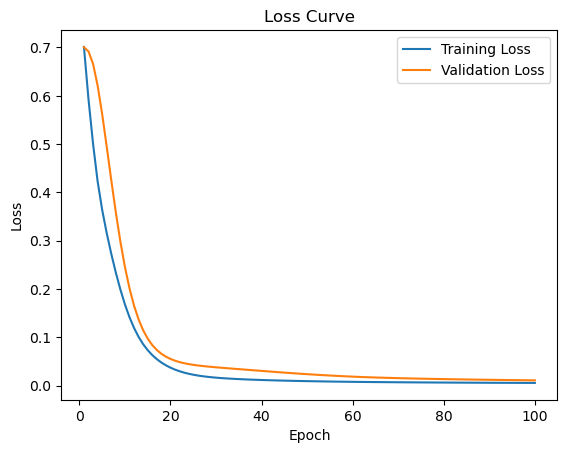

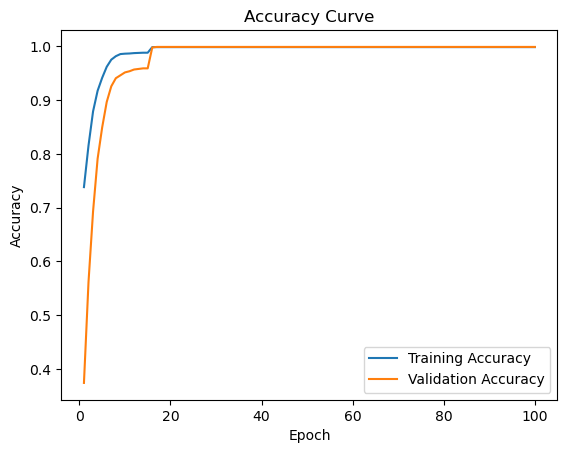

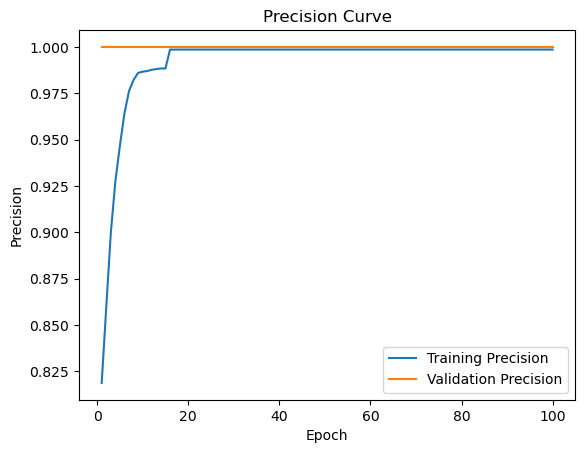

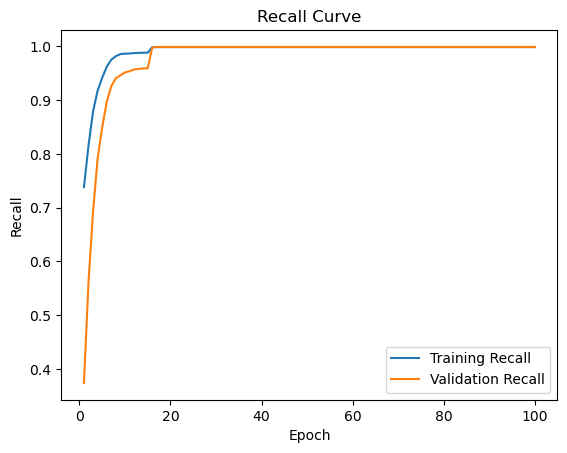

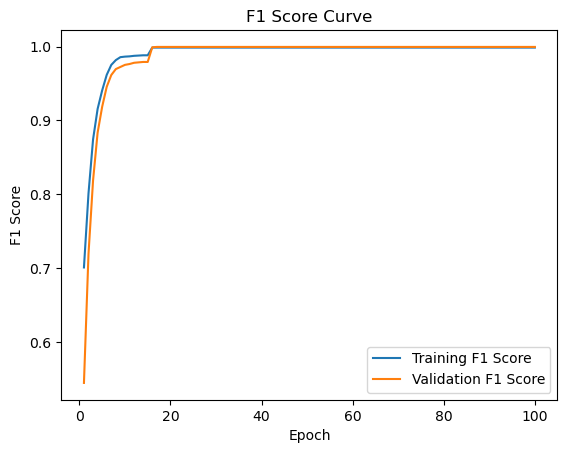

In [5]:
# 그래프 불러오기
G = nx.read_gml('token_graph.gml')

# 노드 이름을 인덱스로 변환
node_list = list(G.nodes)
node_to_index = {node: i for i, node in enumerate(node_list)}

# 엣지를 숫자로 매핑하여 edge_index 생성
edge_index = torch.tensor([(node_to_index[edge[0]], node_to_index[edge[1]]) for edge in G.edges], dtype=torch.long).t().contiguous()

# 데이터 로드
voicephishing_path = 'augmented_transcriptions.xlsx'
ecommerce_path = 'combined_transcriptions.xlsx'

voicephishing_data = pd.read_excel(voicephishing_path)
ecommerce_data = pd.read_excel(ecommerce_path)

# 데이터에 라벨 추가
voicephishing_data['label'] = 1
ecommerce_data['label'] = 0

# 데이터 합치기
combined_data = pd.concat([voicephishing_data, ecommerce_data.sample(n=3000, random_state=42)])

# 'transcript' 열을 문자열로 변환
combined_data['transcript'] = combined_data['transcript'].astype(str)

# TF-IDF 벡터화
vectorizer = TfidfVectorizer(max_features=1000, tokenizer=lambda x: x.split())
X = vectorizer.fit_transform(combined_data['transcript']).toarray()
y = combined_data['label'].values

# PyTorch 텐서로 변환
x = torch.tensor(X, dtype=torch.float)
y = torch.tensor(y, dtype=torch.long)

# 훈련, 검증, 테스트 마스크 설정
num_train = int(0.6 * len(y))
num_val = int(0.2 * len(y))
train_mask = torch.zeros(len(y), dtype=torch.bool)
val_mask = torch.zeros(len(y), dtype=torch.bool)
test_mask = torch.zeros(len(y), dtype=torch.bool)
train_mask[:num_train] = True
val_mask[num_train:num_train+num_val] = True
test_mask[num_train+num_val:] = True

data = Data(x=x, edge_index=edge_index, y=y)
data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

class GNN(nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(data.num_node_features, 16)
        self.conv2 = GCNConv(16, 2)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return torch.log_softmax(x, dim=1)

# 모델, 손실 함수, 최적화기 정의
model = GNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 손실과 정확도 저장용 리스트
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
train_precisions = []
val_precisions = []
train_recalls = []
val_recalls = []
train_f1s = []
val_f1s = []

# 훈련
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

# 평가 함수
def evaluate(mask):
    model.eval()
    with torch.no_grad():
        out = model(data)
        loss = criterion(out[mask], data.y[mask]).item()
        _, pred = out[mask].max(dim=1)
        correct = pred.eq(data.y[mask]).sum().item()
        acc = correct / mask.sum().item()
        precision = precision_score(data.y[mask].cpu(), pred.cpu(), average='weighted')
        recall = recall_score(data.y[mask].cpu(), pred.cpu(), average='weighted')
        f1 = f1_score(data.y[mask].cpu(), pred.cpu(), average='weighted')
    return loss, acc, precision, recall, f1

# 훈련 루프
num_epochs = 100
for epoch in range(num_epochs):
    train_loss = train()
    val_loss, val_acc, val_precision, val_recall, val_f1 = evaluate(data.val_mask)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_acc, train_precision, train_recall, train_f1 = evaluate(data.train_mask)[1:]
    train_accuracies.append(train_acc)
    train_precisions.append(train_precision)
    train_recalls.append(train_recall)
    train_f1s.append(train_f1)
    val_accuracies.append(val_acc)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_f1s.append(val_f1)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}, Train Accuracy: {train_acc}, Val Accuracy: {val_acc}, Train Precision: {train_precision}, Val Precision: {val_precision}, Train Recall: {train_recall}, Val Recall: {val_recall}, Train F1: {train_f1}, Val F1: {val_f1}')

# 손실 곡선 저장
plt.figure()
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.savefig('loss_curve.png')

# 정확도 곡선 저장
plt.figure()
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.savefig('accuracy_curve.png')

# Precision 곡선 저장
plt.figure()
plt.plot(range(1, num_epochs + 1), train_precisions, label='Training Precision')
plt.plot(range(1, num_epochs + 1), val_precisions, label='Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Precision Curve')
plt.legend()
plt.savefig('precision_curve.png')

# Recall 곡선 저장
plt.figure()
plt.plot(range(1, num_epochs + 1), train_recalls, label='Training Recall')
plt.plot(range(1, num_epochs + 1), val_recalls, label='Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Recall Curve')
plt.legend()
plt.savefig('recall_curve.png')

# F1 Score 곡선 저장
plt.figure()
plt.plot(range(1, num_epochs + 1), train_f1s, label='Training F1 Score')
plt.plot(range(1, num_epochs + 1), val_f1s, label='Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Score Curve')
plt.legend()
plt.savefig('f1_score_curve.png')

# 테스트 정확도 평가
test_loss, test_acc, test_precision, test_recall, test_f1 = evaluate(data.test_mask)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_acc}, Test Precision: {test_precision}, Test Recall: {test_recall}, Test F1 Score: {test_f1}')

# 최종 모델 저장
torch.save(model.state_dict(), 'gnn_model.pth')

# 최종 결과 출력
print(f'Final Training Loss: {train_losses[-1]}')
print(f'Final Validation Loss: {val_losses[-1]}')
print(f'Final Test Accuracy: {test_acc}')
print(f'Final Test Precision: {test_precision}')
print(f'Final Test Recall: {test_recall}')
print(f'Final Test F1 Score: {test_f1}')